**1. Using Time Domain Power Spectral Descriptors (TDPSD) Feature Set**  
**2. Using individual dataset**

In [1]:
!pip install libemg

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipyio
import seaborn as sns
import pandas as pd
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler

**Reading Dataset**

In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
gestures_label = {
	 'Thumb_UP' : 0,
	 'Index' : 1,
	 'Right_Angle' : 2,
	 'Peace' : 3,
	 'Index_Little' : 4,
	 'Thumb_Little' : 5,
	 'Hand_Close' : 6,
	 'Hand_Open' : 7,
	 'Wrist_Extension' : 8,
	 'Wrist_Flexion' : 9,
	 'Ulner_Deviation' : 10,
	 'Radial_Deviation' : 11
}

gestures = ['Thumb_UP', 'Index_Little', 'Right_Angle', 'Peace', 'Index', 'Thumb_Little', 'Hand_Close', 'Hand_Open',
	 'Wrist_Extension', 'Wrist_Flexion', 'Ulner_Deviation', 'Radial_Deviation'
]

In [7]:
persons = ["Arifa", "Arnob", "Ashis", "Bayezid", "Bushra", "Choity_new", "Eftekhar",
           "Fahim", "Humaid", "Humayun", "Johir", "Joy", "Mamun", "Noman", "Piyus", "Sazzad",
           "Shafi", "Shourav", "Tamim", "Wadud"]

In [8]:
def get_gesture_label(gesture):
  return gestures_label [gesture];

In [9]:
def scaleTo01(matrix):
  scaler = MinMaxScaler()
  scaler.fit(matrix)
  scaled_matrix = scaler.transform(matrix)
  return scaled_matrix

In [10]:
def feature_extraction(channelvalues, gesture, feature_list):
  # creating windows
  windows = get_windows(channelvalues, 150, 150)
  # extract feature
  fe = FeatureExtractor()
  features = fe.extract_features(feature_list, windows)
  # print(features.keys())
  # creating feature matrixs
  extracted_feature_array = []
  extracted_gesture_array = []
  for i in range(windows.shape[0]):
    features_matrix = []
    for abb in feature_list:
      features_matrix.append(features[abb][i])
    #print(features['MAV'].shape)
    #print(features['AR'].shape)
    #features_matrix = (features_matrix-np.min(features_matrix))/(np.max(features_matrix)-np.min(features_matrix))
    #features_matrix = scaleTo01(features_matrix)
    extracted_feature_array.append(features_matrix)
    extracted_gesture_array.append(get_gesture_label(gesture))
    #print(len(extracted_feature_array))
  return extracted_feature_array, extracted_gesture_array

In [11]:
def get_processed_data(matfilepath, gesture):
  # read mat file
  matdata = scipyio.loadmat(matfilepath)
  # transpose the matrix
  values = np.transpose(matdata['value'])
  # remove the first 3000 values
  values = values[3000:]
  return feature_extraction(values, gesture, feature_list)


In [12]:
def get_input(persons, gestures, feature_list, orientaion="Rest"):
  input_array = []
  input_gest = []
  for person in persons:
    for gest in gestures:
      for i in range(5):
        matfilepath = "gdrive/My Drive/Forearm Invariant Data/"+person+"/"+orientaion+"/"+gest+"-"+str(i+1)+".mat"
        #print(matfilepath)
        processed_matrix, gesture_array = get_processed_data(matfilepath, gest)
        gest_label = get_gesture_label(gest)
        input_array = input_array + processed_matrix
        input_gest = input_gest + gesture_array
  return input_array, input_gest

In [13]:
feature_list = [
    'MAV',
    'SSC',
    'ZC',
    'WL',
    'LS',
    'MFL',
    'MSR',
    'WAMP',
    'RMS',
    'IAV',
    'DASDV',
    'VAR',
    'M0',
    'M2',
    'M4',
    'SPARSI',
    'IRF',
    # 'WLR',
    'LD',
]
X, Y = get_input(['Arifa'], gestures, feature_list)

In [14]:
len(X), len(Y)

(1980, 1980)

In [15]:
#
df = pd.DataFrame(X[0])
index = pd.Index(feature_list)
df = df.set_index(index)
df

,0,1,2,3,4,5,6,7
MAV,0.017122,0.013281,0.036914,0.017578,0.035775,0.021419,0.029264,0.017969
SSC,103.000000,105.000000,100.000000,87.000000,87.000000,91.000000,82.000000,109.000000
ZC,16.000000,31.000000,39.000000,32.000000,34.000000,35.000000,34.000000,51.000000
WL,2.133789,1.962891,6.782227,2.587891,4.282227,2.631836,3.710938,2.910156
LS,0.012341,0.009419,0.026618,0.012105,0.026590,0.015123,0.021282,0.012346
MFL,0.329151,0.292896,0.831372,0.412946,0.631670,0.420259,0.569484,0.463916
MSR,0.083033,0.073767,0.122734,0.087918,0.119557,0.094563,0.109743,0.089472
WAMP,126.000000,124.000000,139.000000,134.000000,137.000000,131.000000,138.000000,134.000000
RMS,0.026631,0.016943,0.049062,0.022305,0.048807,0.026655,0.040967,0.022362
IAV,2.568359,1.992188,5.537109,2.636719,5.366211,3.212891,4.389648,2.695312


In [16]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((1980, 18, 8), (1980,))

**Model Building**

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,Y,
    test_size = .2, shuffle=True, random_state=0
)

In [18]:
len(x_train), len(y_train)

(1584, 1584)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape
input_shape = x_train[0].shape

# Create a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a MaxPooling1D layer (optional)
model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it to a Dense layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

model.add(BatchNormalization()),

# Add a Dense layer
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))

# Add a Dense layer
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.2))

# Output layer for classification (adjust units according to the number of classes)
# Assuming classes are integers starting from 0
model.add(Dense(12, activation='softmax'))

# Compile the model
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            800       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [20]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [21]:
# Fit the model with training data
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 2s 13ms/step - loss: 2.3164 - accuracy: 0.2241 - val_loss: 6.9636 - val_accuracy: 0.1061
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 1.9851 - accuracy: 0.4097 - val_loss: 2.8104 - val_accuracy: 0.1313
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 1.7588 - accuracy: 0.4811 - val_loss: 8.3298 - val_accuracy: 0.0909
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 1.5826 - accuracy: 0.5429 - val_loss: 2.8081 - val_accuracy: 0.2172
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 1.4053 - accuracy: 0.5840 - val_loss: 5.1933 - val_accuracy: 0.2096
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 1.2528 - accuracy: 0.6471 - val_loss: 3.2056 - val_accuracy: 0.1490
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 1.1033 - accuracy: 0.6995 - val_loss: 4.0789 - val_accuracy: 0.2247
Epoch 8/100


**Classification Report**

In [22]:
rest_results = model.evaluate(x_test, y_test, batch_size=32)
print(rest_results)

13/13 [==============================] - 0s 2ms/step - loss: 1.0576 - accuracy: 0.6263
[1.0576269626617432, 0.6262626051902771]


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report : ")
print(classification_report(y_test, y_pred_classes))

13/13 [==============================] - 0s 2ms/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        42
           1       0.35      0.59      0.44        29
           2       1.00      0.03      0.06        32
           3       0.39      0.23      0.29        30
           4       0.58      0.44      0.50        32
           5       0.72      0.79      0.75        29
           6       0.29      0.66      0.40        29
           7       0.90      0.27      0.42        33
           8       0.74      0.97      0.84        36
           9       1.00      0.71      0.83        31
          10       0.63      0.89      0.74        36
          11       0.97      0.92      0.94        37

    accuracy                           0.63       396
   macro avg       0.70      0.61      0.59       396
weighted avg       0.71      0.63      0.60       396



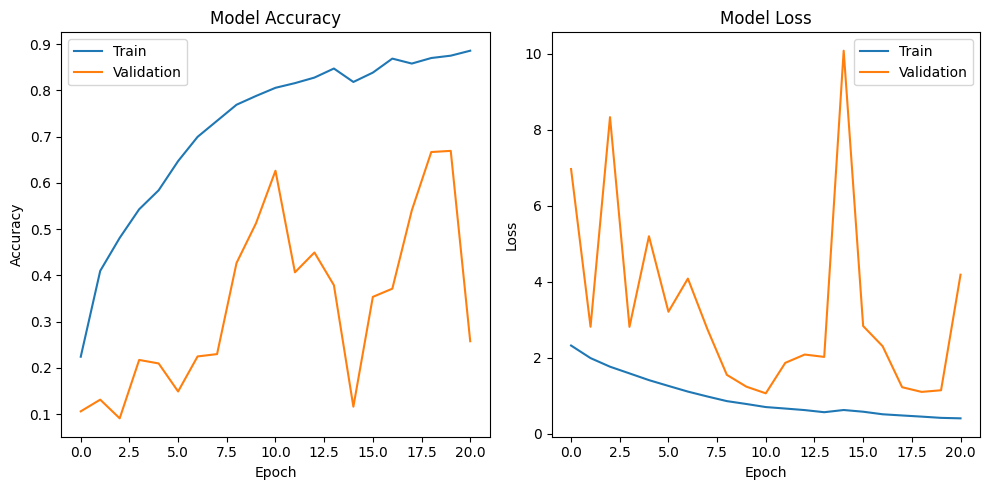

In [32]:
# Plotting model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    #plt.ylim(0, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    #plt.ylim(0, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)

**Validation with Pronation Data**

In [33]:
x_pronation, y_pronation = get_input(['Arifa'], gestures, "Pronation")
x_pronation = np.array(x_pronation)
y_pronation = np.array(y_pronation)

In [34]:
pronation_results = model.evaluate(x_pronation, y_pronation, batch_size=32)
print(pronation_results)

62/62 [==============================] - 0s 2ms/step - loss: 1.0439 - accuracy: 0.6389
[1.0439338684082031, 0.6388888955116272]


**Validation with Supination Data**

In [35]:
x_supination, y_supination = get_input(['Arifa'], gestures, "Supination")
x_supination = np.array(x_supination)
y_supination = np.array(y_supination)

In [36]:
supination_results = model.evaluate(x_supination, y_supination, batch_size=32)
print(supination_results)

62/62 [==============================] - 0s 3ms/step - loss: 1.0439 - accuracy: 0.6389
[1.0439338684082031, 0.6388888955116272]


**Final Report**

In [37]:
print(f"Rest -> {rest_results[1]*100}%")
print(f"Pronation -> {pronation_results[1]*100}%")
print(f"Supination -> {supination_results[1]*100}%")

Rest -> 62.62626051902771%
Pronation -> 63.88888955116272%
Supination -> 63.88888955116272%
